##### Data Background and Columns

This dataset contains sentiment analysis data gathered from Twitter. We scraped the data using sources such as **Al Jazeera, CNN, BBC News, The Federalist,** and a **Kaggle dataset** containing tweets related to the **Israel-Palestine** conflict. Due to API restrictions,**10% of our data is fabricated** to explore its impact on the model's performance and observe any resulting variations.

##### The Dataset

- **Headline:** The title or main heading of the news article or tweet.
- **Description:** A brief summary or explanation of the content.
- **Date:** The publication date of the news article or tweet.
- **Source:** The platform or media outlet where the news or tweet originated.
- **Headline_Tokens:** A list of individual words (tokens) extracted from the headline.
- **Description_Token:** A list of individual words (tokens) extracted from the description
##### Objective

Our goal is to classify and categorize the **dataset's sentiment (positive, negative, or neutral)**. We will then analyze and interpret the results.

## Import and Download libraries
Import necessary libraries like pandas,re(regular expressions), NLTK (for text preprocessing), Scikit-learn (for ML models).
Download NLTK resources like vader_lexicon, punkt, wordnet, and stopwords for sentiment analysis and preprocessing.

In [1]:
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Download necessary NLTK packages
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Steps for loading and prepocessing
- Loading data, preprocessing text (cleaning, lemmatization, stop word removal)
- Vectorizing it using TF-IDF to prepare the data for machine learning tasks

In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
# Load stop words from NLTK
stop_words = set(stopwords.words('english'))

# Load dataset
df = pd.read_csv("transformed_news_data.csv")

#Select Text column for analysis
df['text'] = df['Description'] 

# Convert Text to String and Handle NaNs
df['text'] = df['text'].astype(str).fillna('')

# Preprocessing (Lemmatization, Stop Word Removal, and Cleaning)
def lemmatize_and_remove_stopwords(text):
    """Function to lemmatize text and remove stop words."""
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize and remove stop words
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)
    
## Text Cleaning
def clean_text(text):
    """Function to clean and prepare text for vectorization."""
    text = re.sub(r"http\S+|www\S+|https\S+|@\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'(.)\1{4,}', r'\1', text)  # Remove long repeated characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply preprocessing steps
df['text_lemmatized'] = df['text'].apply(lemmatize_and_remove_stopwords)
df['text_cleaned'] = df['text_lemmatized'].apply(clean_text)

## Steps for Vectorization
- **TfidfVectorizer:** how frequently a word occurs in a document but also how unique it is across the entire dataset.
- **ngram_range=(1, 2):** This specifies that both unigrams (individual words) and bigrams (pairs of consecutive words) will be included in the vectorization process.
- **min_df=5:** This ensures that only words or n-grams that appear in at least 5 documents are included.
- **stop_words='english':** This removes common stop words in English.

In [7]:
# Vectorization using TF-IDF
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, stop_words='english')

##Fit and Transform the Cleaned Text
X_vectorized = vectorizer.fit_transform(df['text_cleaned'])

### Steps for VADER
- Initialized and Prepared the VADER sentiment analyzer.
- Created a function to compute sentiment based on the VADER compound score.
- Applied the function to classify sentiment into positive, neutral, and negative labels.

In [9]:
nltk.download('vader_lexicon')
df['text'] = df['Description'] 
sid = SentimentIntensityAnalyzer()

df['text'] = df['text'].astype(str).fillna('')

def get_vader_sentiment(text):
    sentiment_dict = sid.polarity_scores(text)
    # Classify based on compound score: Positive (1), Neutral (0), Negative (-1)
    if sentiment_dict['compound'] >= 0.05:
        return 1  # Positive
    elif sentiment_dict['compound'] <= -0.05:
        return -1  # Negative
    else:
        return 0  # Neutral

# Step 4: Apply the sentiment function to the 'text' column
df['sentiment_label'] = df['text'].apply(get_vader_sentiment)

# Step 5: Now you can use the labeled sentiment column
df[['text', 'sentiment_label']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,sentiment_label
0,gaza jour­nal­ists be­ing killed un­prece­dent...,-1
1,hun­dreds pales­tini­ans forced evac­u­ate bu­...,-1
2,un se­cu­ri­ty coun­cil pass­es res­o­lu­tion ...,1
3,white house says tehran pro­vid­ing yemeni reb...,-1
4,wa­tered-down res­o­lu­tion boost­ing aid gaza...,0


## Count for various sentiment labels

In [11]:
df['sentiment_label'].value_counts()

sentiment_label
-1    3862
 0    2349
 1    1177
Name: count, dtype: int64

## Plot for sentiment label count

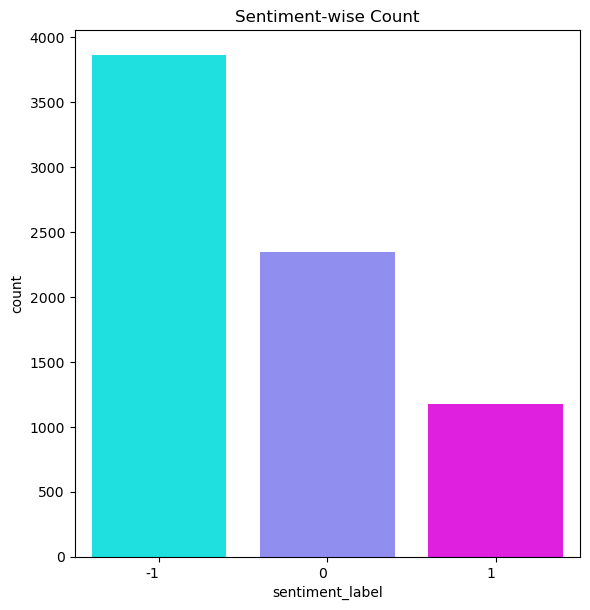

In [13]:
plt.figure(figsize=(6,6))
ax = sns.countplot(
    x="sentiment_label", 
    data=df,
    order=df['sentiment_label'].value_counts().index,
    hue="sentiment_label",
    palette="cool",
    legend=False
)
plt.xticks( ha="right")
plt.tight_layout()
plt.title("Sentiment-wise Count")
plt.show()


### Steps for SMOTE and Vectorization
- Defined the features (X) and target labels (Y)
- Handle Class Imbalance Using SMOTE
- Upsampled the positive sentiment class to match the number of negative samples for class balance
- Combine Upsampled Data
- Re-vectorize After Balancing

In [15]:
X = X_vectorized
Y = df['sentiment_label']  # Sentiment: -1 for negative, 0 for neutral, 1 for positive

# Separate positive, neutral, and negative samples
positive_samples = df[df['sentiment_label'] == 1]
neutral_samples = df[df['sentiment_label'] == 0]
negative_samples = df[df['sentiment_label'] == -1]

# Upsample positive sentiment class
positive_samples_upsampled = positive_samples.sample(n=len(negative_samples), replace=True, random_state=42)

# Combine back the upsampled dataset
df_balanced = pd.concat([positive_samples_upsampled, neutral_samples, negative_samples])

# Re-vectorize after balancing
X_balanced = vectorizer.fit_transform(df_balanced['text_cleaned'])
Y_balanced = df_balanced['sentiment_label']

### Steps for Splitting of data sets
Split data into training and testing sets

In [17]:
# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

## Model 1: Naive Bayes

## Steps for Naive Bayes Classifier and GridSearchCV
- Initialized the Naive Bayes classifier (MultinomialNB()).
- Defined the parameter grid (alpha values) for tuning with grid search with 5-fold cross-validation to find the best alpha.
- Evaluated the model's performance, displaying the best alpha value, accuracy, and classification report.

In [19]:
# Step 6: Initialize Naive Bayes classifier and tune with GridSearchCV
nb_classifier = MultinomialNB()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0]}  # Test different alpha values
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Step 7: Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Step 8: Display results
print(f"Best alpha parameter: {grid_search.best_params_}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best alpha parameter: {'alpha': 0.01}
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

          -1       0.78      0.72      0.75      1119
           0       0.64      0.72      0.68       729
           1       0.83      0.82      0.83      1174

    accuracy                           0.76      3022
   macro avg       0.75      0.76      0.75      3022
weighted avg       0.77      0.76      0.76      3022



### Conclusion
- The optimal value of alpha for the Multinomial Naive Bayes classifier is 0.01
- The model performs well in identifying positive and negative sentiments, with relatively high precision, recall, and F1-scores for those classes
- The accuracy of the model on the test dataset is 0.76, or 76%. This means that the model correctly classified 76% of the test data.

## Steps for inspect important features (words or n-grams)
- Extracted the feature names (words or n-grams) from the vectorized dataset.
- Retrieved the log probabilities
- Sorted the features
- Extracted and displayed the top 20 features

In [21]:
# MultinomialNB uses feature_log_prob_ instead of coef_
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities for each feature (word) for each class
log_probabilities = best_model.feature_log_prob_

# We can inspect the top features for each class
# For example, here we are getting the top features for the positive class (class 1)
top_positive_indices = log_probabilities[1].argsort()[::-1]  # Sort by highest log prob
top_positive_features = [(feature_names[i], log_probabilities[1][i]) for i in top_positive_indices[:20]]

print("Top positive features:")
for feature, score in top_positive_features:
    print(f"{feature}: {score}")

Top positive features:
ing: -4.743370495994045
rael: -5.171746424198782
pales: -5.1767777339863414
tion: -5.351153462077201
gaza: -5.359944037058419
raeli: -5.382376429705603
al: -5.4065007778185645
say: -5.430419220802364
ter: -5.50538174109278
ed: -5.552809040071034
tin: -5.59899238532274
ian: -5.635804811626918
pales tin: -5.732117714942751
tin ian: -5.732117714942751
er: -5.802993676801972
ly: -5.8270462085802786
ment: -5.878164461991312
tini ans: -5.8983496145784855
tini: -5.8983496145784855
pales tini: -5.8983496145784855


In [23]:
import numpy as np

# Assuming log_probabilities is a matrix and you want the top positive log probabilities (second column)
top_positive_indices = np.argsort(log_probabilities[1])[::-1]  # Sort indices in descending order
top_positive_features = [(feature_names[i], log_probabilities[1][i]) for i in top_positive_indices[:20]]

# Convert the list of tuples into a pandas DataFrame
df_top_positive_features = pd.DataFrame(top_positive_features, columns=['Feature', 'Log Probability'])
df_top_positive_features


,Feature,Log Probability
0,ing,-4.743370
1,rael,-5.171746
2,pales,-5.176778
3,tion,-5.351153
4,gaza,-5.359944
5,raeli,-5.382376
6,al,-5.406501
7,say,-5.430419
8,ter,-5.505382
9,ed,-5.552809


## Plot for Top Positive Features by Log Probability

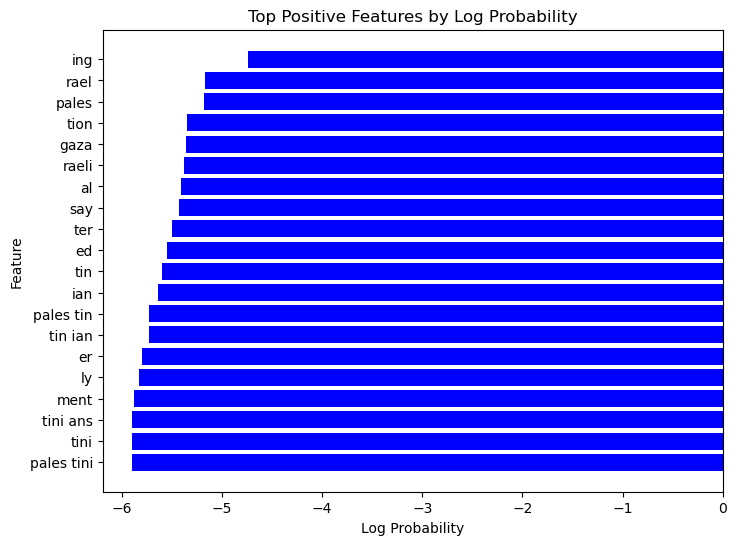

In [25]:
# Sort the dataframe by 'Log Probability' in descending order for the bar chart
df_top_positive_features_sorted = df_top_positive_features.sort_values(by='Log Probability', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.barh(df_top_positive_features_sorted['Feature'], df_top_positive_features_sorted['Log Probability'], color='blue')
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.title('Top Positive Features by Log Probability')
plt.gca().invert_yaxis()  # To display the highest log probability at the top
plt.show()


## Model 2: Support Vector Classifier

Support Vector Classifier (SVC) is a classification algorithm based on Support Vector Machines (SVM). It's useful for sentiment analysis because of its common when dealing with text data (e.g., using TF-IDF or bag-of-words).

**Key reasons to use SVC**

- Effective in High-Dimensional Spaces
- Handles Non-Linearity
- Robustness

In [27]:
from sklearn.svm import SVC
svc_model=SVC()
svc_model.fit(X_train, y_train)
svc_prediction=svc_model.predict(X_test)
svc_score=svc_model.score(X_test, y_test)
# Model fit and accuracy
print('Accuracy of Support Vector Classifier on training set: {:.2f}'.format(svc_model.score(X_train, y_train)))
print('Accuracy of Support Vector Classifier on test set:     {:.2f}'.format(svc_model.score(X_test, y_test)))
#Mean Squared Error
svc_mse = mean_squared_error(y_test, svc_prediction)
print(svc_mse)

Accuracy of Support Vector Classifier on training set: 0.99
Accuracy of Support Vector Classifier on test set:     0.85
0.2504963600264725


In [29]:
accuracy = accuracy_score(y_test, svc_prediction)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, svc_prediction))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

          -1       0.80      0.85      0.83      1119
           0       0.77      0.71      0.74       729
           1       0.94      0.93      0.93      1174

    accuracy                           0.85      3022
   macro avg       0.84      0.83      0.83      3022
weighted avg       0.85      0.85      0.85      3022



In [31]:
#Confusion Matrix
svc_cm = confusion_matrix(y_test, svc_prediction, labels=[-1, 0, 1])
svc_cm

array([[ 956,  122,   41],
       [ 181,  514,   34],
       [  56,   32, 1086]], dtype=int64)

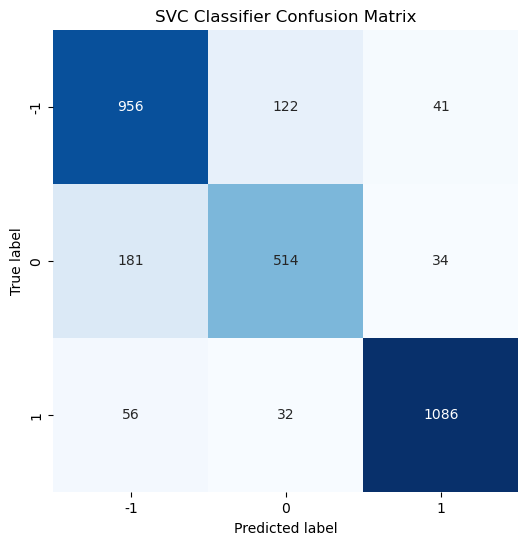

In [33]:
# Plot heatmap with correct labels
plt.figure(figsize=(6,6))
plt.title("SVC Classifier Confusion Matrix")
sns.heatmap(svc_cm, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

**Interpretation**
- Class -1 and Class 1  have good precision, recall, and F1 scores, meaning the model handles these classes well.
- Class 0  has slightly lower scores, indicating that the model struggles more with neutral sentiments.
- The overall accuracy (85%) and the balance in the confusion matrix and classification report suggest the model is performing well.

### Model 3: K-Nearest Neighbors (KNN)

In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [37]:
from sklearn.neighbors import KNeighborsClassifier
classifier_KN = OneVsRestClassifier(KNeighborsClassifier())
classifier_KN.fit(X_train, y_train)
knn_prediction = classifier_KN.predict(X_test)
knn_score = classifier_KN.score(X_test,y_test)
#Model fit and accuracy
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(classifier_KN.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(classifier_KN.score(X_test, y_test)))
#Mean Squared Error

knn_mse = mean_squared_error(y_test, knn_prediction)
print(knn_mse)

Accuracy of KNeighbors Classifier on training set: 0.79
Accuracy of KNeighbors Classifier on test set:     0.64
0.7544672402382528


In [39]:
accuracy = accuracy_score(y_test, knn_prediction)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, knn_prediction))

Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.63      0.63      1119
           0       0.54      0.50      0.52       729
           1       0.71      0.75      0.73      1174

    accuracy                           0.64      3022
   macro avg       0.63      0.63      0.63      3022
weighted avg       0.64      0.64      0.64      3022



In [41]:
# Generate confusion matrix with specified labels
knn_cm = confusion_matrix(y_test, knn_prediction, labels=[-1, 0, 1])

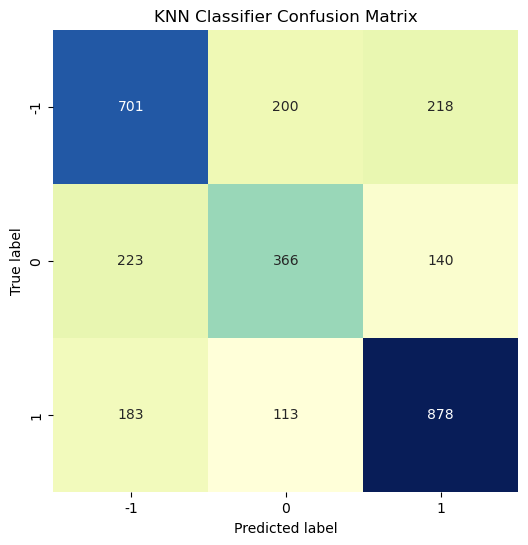

In [43]:
# Plot heatmap with correct labels
plt.figure(figsize=(6,6))
plt.title("KNN Classifier Confusion Matrix")
sns.heatmap(knn_cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


**Interpretation**
- Class -1  has moderate precision, recall, and F1-scores,at 0.63, indicating that the model is fairly effective in identifying negative sentiments.
- Class 0  has the lowest performance, with precision at 0.54, recall at 0.50, and an F1-score of 0.52. These lower scores indicate that the model is having difficulty distinguishing neutral sentiments from the other classes.
- Class 1  has relatively higher precision, recall, and F1-scores, with precision at 0.71, recall at 0.75, and an F1-score of 0.73. This suggests that the model handles positive sentiment classification better than neutral or negative.
- Overall accuracy is 64%, which indicates that the model is not performing as well as desired, especially for distinguishing between neutral and other sentiments.

### Model 4: Decision Tree

A Decision Tree (DT) classifier works by splitting the data into subsets based on the most informative features. It creates a tree-like structure where each node represents a decision based on a feature, and the leaves represent the final output or classification.

**Key reasons to use a Decision Tree**

- Interpretability
- No Feature Scaling Needed: Unlike some algorithms (e.g., SVM, KNN), Decision Trees don't require scaling of features
- Handles Non-Linear Relationships: Decision Trees can handle both linear and non-linear relationships well by splitting the data based on feature thresholds.
- Overfitting Tendency

In [45]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(X_train, y_train)
DT_prediction = classifier_DT.predict(X_test)
DT_score = classifier_DT.score(X_test,y_test)
# Model fit and accuracy
print('Accuracy of DT Classifier on training set: {:.2f}'.format(classifier_DT.score(X_train, y_train)))
print('Accuracy of DT Classifier on test set:     {:.2f}'.format(classifier_DT.score(X_test, y_test)))
#Mean Squared Error
DT_mse = mean_squared_error(y_test, DT_prediction)
print(DT_mse)

Accuracy of DT Classifier on training set: 1.00
Accuracy of DT Classifier on test set:     0.78
0.38517538054268696


In [47]:
accuracy = accuracy_score(y_test, DT_prediction)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, DT_prediction))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

          -1       0.80      0.74      0.76      1119
           0       0.69      0.62      0.65       729
           1       0.82      0.93      0.87      1174

    accuracy                           0.78      3022
   macro avg       0.77      0.76      0.76      3022
weighted avg       0.78      0.78      0.78      3022



In [49]:
#Confusion Matrix
DT_cm = confusion_matrix(y_test, DT_prediction, labels=[-1, 0, 1])
DT_cm

array([[ 824,  163,  132],
       [ 173,  450,  106],
       [  39,   38, 1097]], dtype=int64)

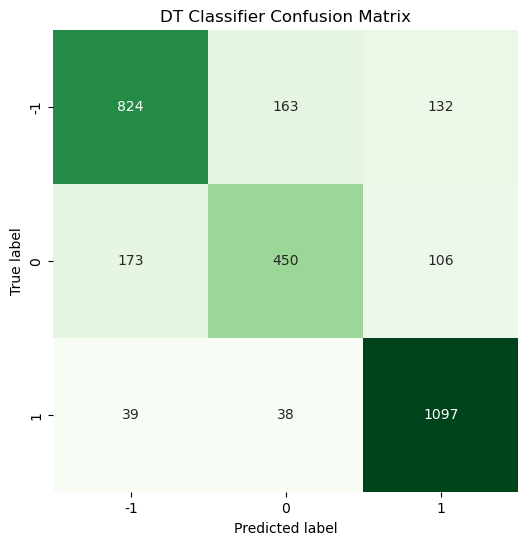

In [51]:
# Plot heatmap with correct labels
plt.figure(figsize=(6,6))
plt.title("DT Classifier Confusion Matrix")
sns.heatmap(DT_cm, annot=True, cmap="Greens", fmt="d", cbar=False, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [53]:
print("The dataset has", df.shape[0], "observations, and", df.shape[1], "variables") 
print("We have", df['sentiment_label'].shape[0], "records for target")
features = df.columns.drop('sentiment_label')
print("The variables are", list(features)) 
print("The targets are", df['sentiment_label'].unique()) 

The dataset has 7388 observations, and 10 variables
We have 7388 records for target
The variables are ['Headline', 'Description', 'Date', 'Source', 'Headline_Tokens', 'Description_Tokens', 'text', 'text_lemmatized', 'text_cleaned']
The targets are [-1  1  0]


In [55]:
from sklearn.tree import DecisionTreeClassifier

dt_full= DecisionTreeClassifier(random_state=0)
dt_full.fit(X_train,y_train)
dt_full.score(X_test,y_test), dt_full.score(X_train,y_train)

(0.7819324950363997, 1.0)

In [57]:
# Let maximum depth be 3

from sklearn.tree import DecisionTreeClassifier

# A Basic Tree
dt_3= DecisionTreeClassifier(max_depth = 3, random_state = 0 )
dt_3.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [59]:
dt_3.score(X_train,y_train), dt_3.score(X_test,y_test)

(0.5531130336122536, 0.5403706154864328)

In [61]:
# GridSearch + CV
from sklearn.model_selection import GridSearchCV
#random_state throughout the process it is fixed through the tuning process
#opt_tree = DecisionTreeClassifier(random_state = 0,criterion='entropy')

opt_tree = DecisionTreeClassifier(random_state = 0)
#tuning multiple hyperparameters
dt_params = {'max_depth':  range(1,10)         ,
             'min_samples_split':   range(2,11),
             'max_leaf_nodes':    range(2,11)   }

grid_tree = GridSearchCV(opt_tree, dt_params)
grid_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(1, 10),
                         'max_leaf_nodes': range(2, 11),
                         'min_samples_split': range(2, 11)})

In [63]:
grid_tree.best_params_

{'max_depth': 9, 'max_leaf_nodes': 10, 'min_samples_split': 2}

In [65]:
from sklearn import tree
print(tree.export_text(grid_tree.best_estimator_))

|--- feature_5281 <= 0.08
|   |--- feature_10484 <= 0.10
|   |   |--- feature_4624 <= 0.08
|   |   |   |--- feature_662 <= 0.11
|   |   |   |   |--- feature_7624 <= 0.09
|   |   |   |   |   |--- feature_6805 <= 0.09
|   |   |   |   |   |   |--- feature_10208 <= 0.09
|   |   |   |   |   |   |   |--- feature_3623 <= 0.07
|   |   |   |   |   |   |   |   |--- feature_281 <= 0.09
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_281 >  0.09
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_3623 >  0.07
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |--- feature_10208 >  0.09
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_6805 >  0.09
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_7624 >  0.09
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_662 >  0.11
|   |   |   |   |--- class: -1
|   |   |--- feature_4624 >  0.08
|   |   |

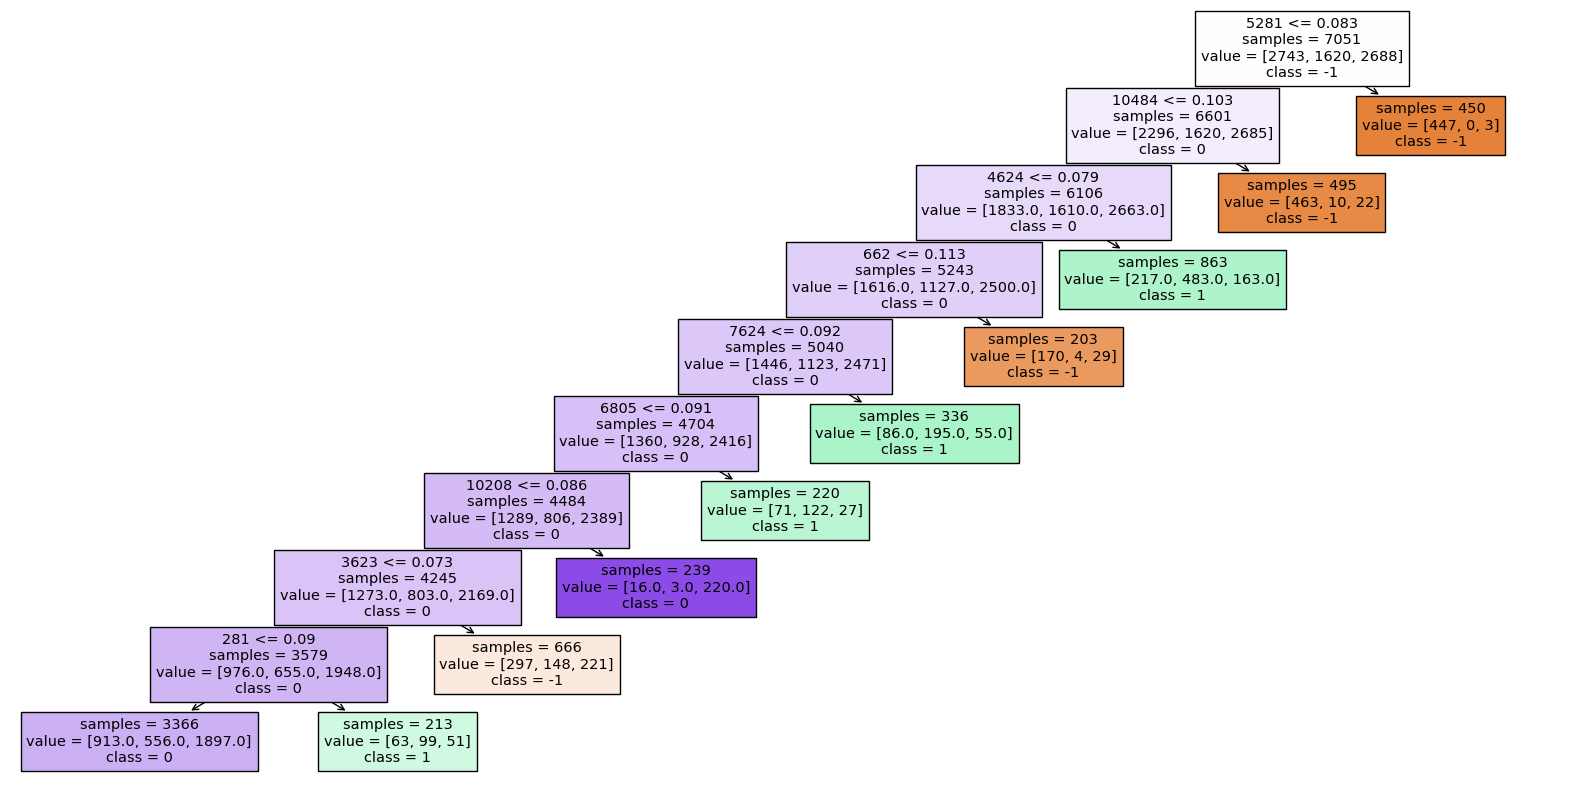

In [67]:
from sklearn import tree
import matplotlib.pyplot as plt

# Check if features match the trained model
features = X_train.columns if hasattr(X_train, 'columns') else list(range(X_train.shape[1]))
class_names = list(df['sentiment_label'].unique().astype(str))

fig = plt.figure(figsize=(20, 10))  # Set a proper figure size

tree.plot_tree(grid_tree.best_estimator_, 
               feature_names=features,  # Specify feature names
               class_names=class_names,  # Specify class (Y) names
               filled=True, impurity=False)

plt.show()


**Based on Decision Tree Interpretation**
- The root and early nodes show more balanced splits across classes, but as the tree progresses deeper, specific features drive the classification toward one class (such as class 0 or class -1).
- The model is quite confident in many leaf nodes, as indicated by highly skewed class distributions and distinct colors representing a clear majority class.

**Interpretation**
- Class -1  and Class 1  have relatively good precision, recall, and F1 scores, indicating that the Decision Tree model handles these classes well.
- Class 0  has lower scores, particularly in recall (0.59), indicating that the model struggles more with neutral sentiments.
- The overall accuracy of 77% and the balance between the confusion matrix and classification report suggest that the Decision Tree model is performing reasonably well.

### Model 5: GradientBoostingClassifier

A Gradient Boosting Classifier is an ensemble learning technique that combines multiple weak learners (usually decision trees) into a strong classifier. Each new tree corrects the errors made by the previous ones, which helps to improve the model's performance iteratively. Gradient Boosting is popular for its ability to produce accurate models, especially when dealing with complex datasets.

**Key reasons to use Gradient Boosting**

- High Accuracy
- Flexibility
- Handles Non-Linear Data
- Reduced Overfitting

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_GB = GradientBoostingClassifier()
classifier_GB.fit(X_train, y_train)
GB_prediction = classifier_GB.predict(X_test)
GB_score=classifier_GB.score(X_test, y_test)
# Model fit and accuracy
print('Accuracy of Gradient Boosting Classifier on training set: {:.2f}'.format(classifier_GB.score(X_train, y_train)))
print('Accuracy of Gradient Boosting Classifier on test set:     {:.2f}'.format(classifier_GB.score(X_test, y_test)))
#Mean Squared Error
GB_mse = mean_squared_error(y_test, GB_prediction)
print(GB_mse)

Accuracy of Gradient Boosting Classifier on training set: 0.80
Accuracy of Gradient Boosting Classifier on test set:     0.75
0.5555923229649239


In [71]:
accuracy = accuracy_score(y_test, GB_prediction)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, GB_prediction))

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.68      0.77      1119
           0       0.74      0.63      0.68       729
           1       0.68      0.90      0.78      1174

    accuracy                           0.75      3022
   macro avg       0.77      0.74      0.74      3022
weighted avg       0.77      0.75      0.75      3022



In [73]:
#Confusion Matrix
GB_cm = confusion_matrix(y_test, GB_prediction, labels=[-1, 0, 1])
GB_cm

array([[ 757,  102,  260],
       [  38,  462,  229],
       [  52,   62, 1060]], dtype=int64)

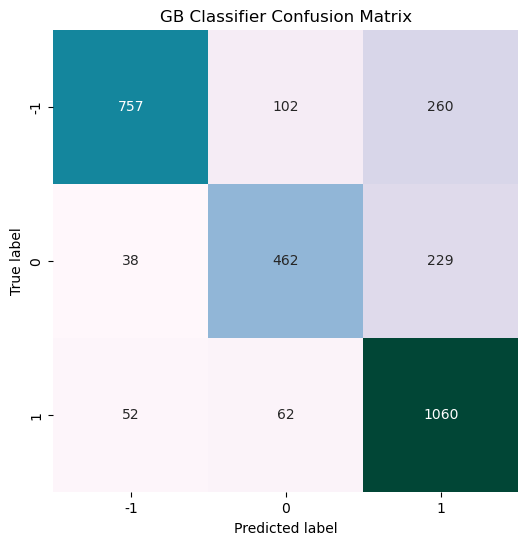

In [75]:
# Plot heatmap with correct labels
plt.figure(figsize=(6,6))
plt.title("GB Classifier Confusion Matrix")
sns.heatmap(GB_cm, annot=True, cmap="PuBuGn", fmt="d", cbar=False, xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

**Interpretation**
- Class -1  has good precision, recall, and F1 scores, meaning the model handles this class relatively well, though the recall of 68% shows there is chance for identifying more true negative instances.
- Class 1 also has relatively good performance, with strong precision and recall, meaning the model is effective at identifying positive sentiments.
- Class 0 (Neutral Sentiment) has slightly lower scores, particularly in recall (0.64), indicating that the model struggles more with neutral sentiments and sometimes confuses them with negative or positive sentiments.
- The overall accuracy of 75% and the performance reflected in the classification report and confusion matrix suggest that the Gradient Boosting model is performing well but could benefit from further tuning to improve the handling of neutral sentiments.







## Model Performance Comparison

In [77]:
# Function to retrieve precision, recall, f1-score for each class, and macro/weighted averages
def get_classification_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    
    metrics = {
        "Accuracy": accuracy,
        "Class -1 Precision": report["-1"]["precision"],
        "Class -1 Recall": report["-1"]["recall"],
        "Class -1 F1": report["-1"]["f1-score"],
        "Class 0 Precision": report["0"]["precision"],
        "Class 0 Recall": report["0"]["recall"],
        "Class 0 F1": report["0"]["f1-score"],
        "Class 1 Precision": report["1"]["precision"],
        "Class 1 Recall": report["1"]["recall"],
        "Class 1 F1": report["1"]["f1-score"],
        "Macro Avg F1": report["macro avg"]["f1-score"],
        "Weighted Avg F1": report["weighted avg"]["f1-score"]
    }
    
    return metrics

# Define model names and corresponding predictions
models = {
    "K-Nearest Neighbors (KNN)": knn_prediction,
    "Support Vector Classifier (SVC)": svc_prediction,
    "Decision Tree (DT)": DT_prediction,
    "Gradient Boosting (GB)": GB_prediction,
    "Naive Bayes (MultinomialNB)": y_pred  # replace with your actual Naive Bayes prediction
}

# Assuming y_test is your actual test labels
metrics_data = []
for model_name, predictions in models.items():
    metrics = get_classification_metrics(y_test, predictions)
    metrics["Model"] = model_name
    metrics_data.append(metrics)

# Create a DataFrame for the metrics
df_performance = pd.DataFrame(metrics_data)

# Re-arrange the columns to put 'Model' first
df_performance = df_performance[['Model'] + [col for col in df_performance.columns if col != 'Model']]

# Display the table using pandas
df_performance


,Model,Accuracy,Class -1 Precision,Class -1 Recall,Class -1 F1,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 1 Precision,Class 1 Recall,Class 1 F1,Macro Avg F1,Weighted Avg F1
0,K-Nearest Neighbors (KNN),0.643614,0.633243,0.626452,0.629829,0.539028,0.502058,0.519886,0.710356,0.747871,0.728631,0.626115,0.641690
1,Support Vector Classifier (SVC),0.845797,0.801341,0.854334,0.826990,0.769461,0.705075,0.735863,0.935401,0.925043,0.930193,0.831015,0.845100
2,Decision Tree (DT),0.784580,0.795367,0.736372,0.764733,0.691244,0.617284,0.652174,0.821723,0.934412,0.874452,0.763786,0.780204
3,Gradient Boosting (GB),0.754136,0.893743,0.676497,0.770092,0.738019,0.633745,0.681919,0.684312,0.902896,0.778553,0.743521,0.752109
4,Naive Bayes (MultinomialNB),0.760754,0.776923,0.722073,0.748495,0.637910,0.720165,0.676546,0.833477,0.822828,0.828118,0.751053,0.762071


### Comparison of all Models
- **Overall Accuracy**

SVC maintains the best accuracy at 85%, while Naive Bayes performs similarly to the Decision Tree at 76% and Gradient Boosting at 75%. KNN still has the lowest accuracy at 64%.

- **Performance on Class -1 (Negative Sentiment):**

Gradient Boosting leads in precision for negative sentiment with 0.89, but Naive Bayes performs similarly to the Decision Tree in terms of recall and F1, with a precision of 0.78 and an F1 score of 0.75.

- **Performance on Class 0 (Neutral Sentiment):**

Naive Bayes has a recall of 0.72 for neutral sentiment, which is slightly better than Gradient Boosting (0.64) and Decision Tree (0.59). SVC performs the best here with F1 of 0.74, while Naive Bayes follows with 0.68.

- **Performance on Class 1 (Positive Sentiment):**

SVC and Naive Bayes have similar high performance on positive sentiment, with Naive Bayes achieving precision (0.83) and F1-score (0.83), which is quite comparable to SVC's performance. Decision Tree and Gradient Boosting also handle positive sentiment well but are slightly behind.

## Summary
- **Best Overall Model:** SVC remains the best overall choice for balanced sentiment classification with the highest accuracy and strong performance across all classes.

- **Naive Bayes:** This model shows strong performance, especially with high precision and recall for both negative and positive sentiments. It performs particularly well on neutral sentiment with a recall of 0.72, making it a good option when prioritizing correct identification of neutral sentiment.

- **Gradient Boosting:** This model achieves the highest precision for negative sentiment and remains a strong option when high accuracy in negative sentiment classification is required.

- **Decision Tree:** Offers a good balance of performance, particularly with positive sentiment, and is easy to interpret and deploy.

- **KNN:** While it performs the worst among all models, it can still be useful for simpler datasets or when computational resources are limited.

Naive Bayes stands out in this analysis as a simpler but effective model, showing strong performance and balance, especially considering its high recall for neutral sentiments, making it a good competitor against more complex models like SVC.




In [79]:
# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Define the parameter grid
param_grid = {
    'penalty': ['l2'],  # L2 regularization is supported by lbfgs solver
    'C': [0.1, 1.0, 10],  # Inverse regularization strength
    'solver': ['lbfgs'],  # Use a solver that supports L2 penalty
    'max_iter': [1000]
}

# Grid search
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Make predictions with the best model
y_pred = grid_search.predict(X_test)

# Evaluate the best model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters found:  {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8557246856386499

Classification Report:
               precision    recall  f1-score   support

          -1       0.88      0.82      0.85      1119
           0       0.78      0.78      0.78       729
           1       0.89      0.94      0.91      1174

    accuracy                           0.86      3022
   macro avg       0.85      0.85      0.85      3022
weighted avg       0.86      0.86      0.86      3022



In [81]:
# Get the best logistic regression model
best_log_reg_model = grid_search.best_estimator_

# Get feature names from TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities (coefficients) of the features
log_probabilities = best_log_reg_model.coef_  # Coefficients for the class (best model from grid search)

# Identify the top positive features for the positive class (class '1')
top_positive_indices = np.argsort(log_probabilities[0])[::-1]  # Sort features by log probability for class 1

# Extract top positive features
top_positive_features = [(feature_names[i], log_probabilities[0][i]) for i in top_positive_indices[:20]]

# Convert the list of tuples into a pandas DataFrame
df_top_positive_features = pd.DataFrame(top_positive_features, columns=['Feature', 'Log Probability'])
df_top_positive_features

,Feature,Log Probability
0,war,16.950460
1,killed,16.063255
2,killing,10.436756
3,attack,8.908269
4,protest,7.633293
5,fear,7.366798
6,strike,7.166821
7,forced,6.764887
8,dead,6.322981
9,protester,6.051635


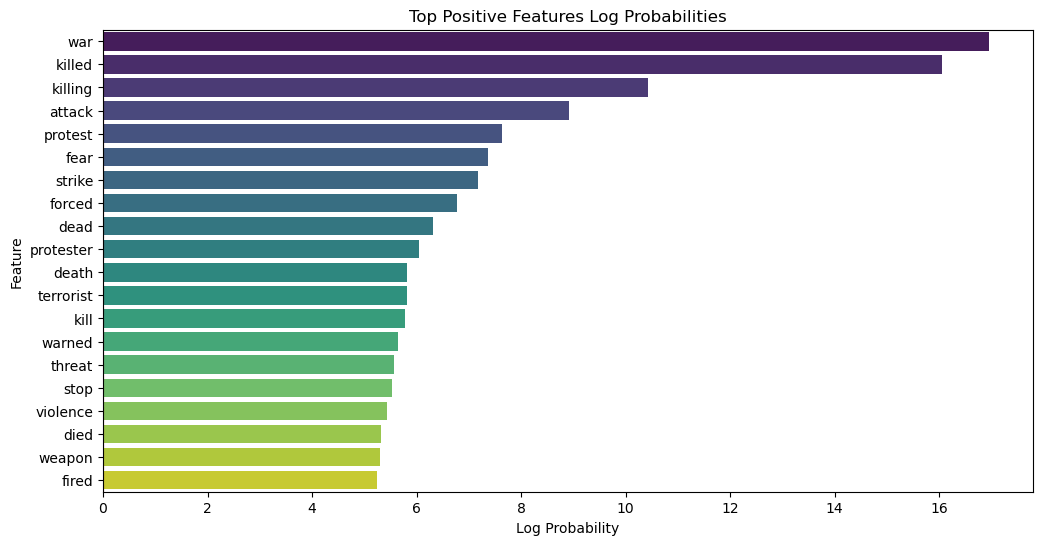

In [83]:
# Plotting the log probabilities
plt.figure(figsize=(12, 6))
sns.barplot(x='Log Probability', y='Feature', data=df_top_positive_features, hue='Feature', palette='viridis', legend=False)
plt.title('Top Positive Features Log Probabilities')
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.axvline(x=0, color='red', linestyle='--')  # Optional: Line at x=0 for reference
plt.show()

In [85]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
}

# Perform Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# Train the best model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Print evaluation results
print("Best Parameters:", grid_search_rf.best_params_)
print("Random Forest Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", class_report_rf)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Accuracy: 0.8352084712111185
Confusion Matrix:
 [[ 960  130   29]
 [ 237  475   17]
 [  54   31 1089]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.77      0.86      0.81      1119
           0       0.75      0.65      0.70       729
           1       0.96      0.93      0.94      1174

    accuracy                           0.84      3022
   macro avg       0.82      0.81      0.82      3022
weighted avg       0.84      0.84      0.83      3022



In [87]:
# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_names = vectorizer.get_feature_names_out()  # Get feature names from TF-IDF vectorizer
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 20 important features
top_important_features = importance_df.head(20)
top_important_features

,Feature,Importance
10484,war,0.010671
5281,killed,0.010569
3623,gaza,0.007308
4624,ing,0.005837
4871,israel,0.005158
662,attack,0.004481
4968,israeli,0.004349
7624,rael,0.003972
4028,hamas,0.003913
6805,pales,0.003635


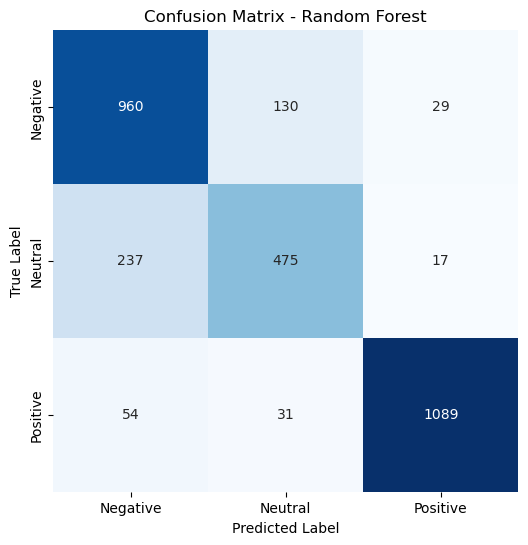

In [89]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

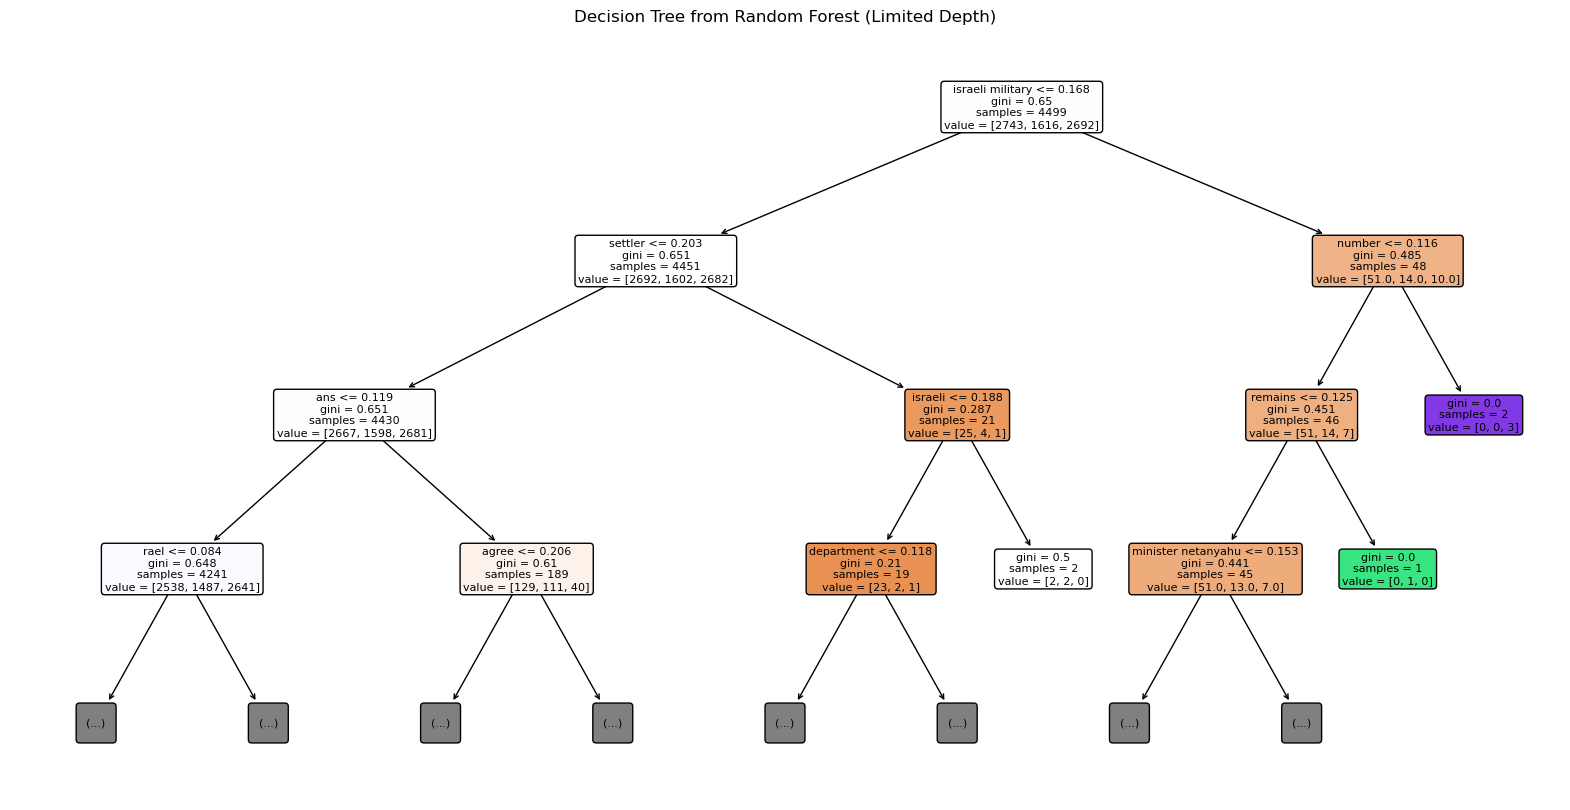

In [91]:
# Extract the last tree from the random forest
tree = best_rf_model.estimators_[-35]  # Last tree in the forest

# Convert feature_names (from NumPy array) to a Python list
feature_names_list = feature_names.tolist()

# Plot the tree using matplotlib with a max depth to make it more readable
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=feature_names_list, filled=True, rounded=True, fontsize=8, max_depth=3)  # Adjust max_depth to your preference
plt.title("Decision Tree from Random Forest (Limited Depth)")
plt.show()